# This notebook was ran in Google Colab and uses the saved finetuned BERT model on my drive to compare performance with a Closed source LLM (Claude Haiku)
# This still a work in progress and further optimizations will be made over the upcoming days
# Test set prep

In [1]:
!pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=157579e8a8c6249cdc588843cca5982c0d6f578ee853bc88a0e52ac04157d558
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency reso

In [4]:
import pandas as pd
import numpy as np
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("gtfintechlab/finer-ord", split='test')
test_df = pd.DataFrame(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
def group_by_sentence(df):
    """
    Converts token-level DataFrame to sentence-level DataFrame where each row contains
    just the sentence tokens and corresponding labels.

    Args:
        df (pd.DataFrame): DataFrame with columns ['gold_label', 'gold_token', 'doc_idx', 'sent_idx']

    Returns:
        pd.DataFrame: DataFrame with columns ['tokens', 'labels']
    """
    # Convert None values to the string "None" in gold_token column
    df['gold_token'] = df['gold_token'].fillna("None")

    # Group by both document and sentence indices
    grouped = df.groupby(['doc_idx', 'sent_idx']).agg({
        'gold_token': list,
        'gold_label': list
    }).reset_index()

    # Keep only the relevant columns and rename them
    return grouped[['gold_token', 'gold_label']].rename(columns={
        'gold_token': 'words',
        'gold_label': 'labels'
    })

test_df = group_by_sentence(test_df)

In [6]:
test_df.tail()

,words,labels
1070,"[Outsiders, take, over, GOP, Conservatives, ar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1071,"[Clinton, will, turn, over, email, ...]","[1, 0, 0, 0, 0, 0]"
1072,"[The, server, reportedly, contained, emails, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1073,"[Jesse, Ventura, open, to, playing, ...]","[1, 2, 0, 0, 0, 0]"
1074,"[Former, Minnesota, Gov, ., Jesse, Ventura, su...","[0, 3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Evaluating finetuned BERT

In [4]:
from google.colab import drive
from transformers import AutoModelForTokenClassification, AutoTokenizer


drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/models/FiNER-BERT"

# Load the model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Mounted at /content/drive


In [5]:
from torch.utils.data import Dataset

class FinerDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=None):
        """
        Input:
        dataframe: a Pandas dataframe with 'words' (list of tokens) and 'labels' (list of NER tags)
        tokenizer: BertTokenizerFast instance
        max_length: maximum sequence length for truncation (if needed)
        """
        self.data = dataframe
        self.tokenized_inputs = []

        # Tokenize all sentences
        for _, row in self.data.iterrows():
            # Tokenize the input
            tokens = tokenizer(
                row['words'],
                is_split_into_words=True,
                truncation=True if max_length else False,
                max_length=max_length,
            )
            tokens.pop('token_type_ids')

            # Get word IDs and align labels
            word_ids = tokens.word_ids()
            aligned_labels = self._align_labels(row['labels'], word_ids)

            # Store tokenized input with aligned labels
            tokens['labels'] = aligned_labels
            self.tokenized_inputs.append(tokens)

    def __getitem__(self, index):
        """Return the dictionary of inputs at the specified index"""
        return self.tokenized_inputs[index]

    def __len__(self):
        return len(self.tokenized_inputs)

    def _align_labels(self, labels, word_ids):
        # Define a mapping from beginning (B-) labels to inside (I-) labels
        begin2inside = {
            1: 2,  # B-PER -> I-PER
            3: 4,  # B-LOC -> I-LOC
            5: 6,  # B-ORG -> I-ORG
        }

        # Initialize an empty list to store aligned labels and a variable to track the last word
        aligned_labels = []
        last_word = None

        # Iterate through the word_ids
        for word in word_ids:
            if word is None:
                label = -100  # Set label to -100 for None word_ids
            elif word != last_word:
                label = labels[word]  # Use the label corresponding to the current word_id
            else:
                label = labels[word]
                # Change B- to I- if the previous word is the same
                if label in begin2inside:
                    label = begin2inside[label]  # Map B- to I-

            # Append the label to the align_labels list and update last_word
            aligned_labels.append(label)
            last_word = word

        return aligned_labels

In [6]:
from transformers import DataCollatorForTokenClassification

test_dataset = FinerDataset(test_df, tokenizer)

# Initialize data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
)

In [7]:
from torch.utils.data import DataLoader
import torch

num_workers = 2
batch_size = 8

torch.manual_seed(123)

# Create data loader

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=data_collator,
    drop_last=False
)
print(f"{len(test_loader)} test batches")

135 test batches


In [8]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

def compute_metrics(predictions, labels):
    def parse_classification_report(cr):
        out = {
            'PER_f1': None,
            'LOC_f1': None,
            'ORG_f1': None
        }
        arr = cr.split('\n')
        arr = [a.split() for a in arr if a.strip()]
        for a in arr:
            if a[0] in ['PER', 'LOC', 'ORG']:
                out[f'{a[0]}_f1'] = a[3]
        out['weighted_avg_f1'] = arr[-1][3]
        return out
    # Convert numeric labels to BIO tags
    id2label = {
        0: 'O',
        1: 'B-PER', 2: 'I-PER',
        3: 'B-LOC', 4: 'I-LOC',
        5: 'B-ORG', 6: 'I-ORG'
    }

    # predictions is a list of arrays, each containing logits for one sequence
    # Convert logits to tag indices
    pred_tags = []
    true_tags = []

    # Process each sequence
    for pred_logits, label_ids in zip(predictions, labels):
        # Convert logits to tag indices for this sequence
        pred_ids = np.argmax(pred_logits, axis=-1)

        # Convert IDs to tag names
        pred_tags.append([id2label[p] for p in pred_ids])
        true_tags.append([id2label[l] for l in label_ids])


    # Calculate weighted average
    cr = classification_report(true_tags, pred_tags, mode='strict', scheme=IOB2)

    return parse_classification_report(cr)

In [9]:
def evaluate_model(model, dataloader, device, num_batches=None):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if num_batches and i >= num_batches:
                break

            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            total_loss += outputs.loss.item()

            # Get predictions for this batch
            predictions = outputs.logits.cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            masks = batch['attention_mask'].cpu().numpy()

            # For each sequence in the batch
            for pred, label, mask in zip(predictions, labels, masks):
                # Get valid indices
                valid_indices = (mask.astype(bool)) & (label != -100)
                all_predictions.append(pred[valid_indices])
                all_labels.append(label[valid_indices])

    # Calculate average loss
    avg_loss = total_loss / (num_batches if num_batches else len(dataloader))

    metrics = compute_metrics(all_predictions, all_labels)
    metrics['loss'] = avg_loss

    return metrics

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set model to eval mode
model.eval()


print("Testing finetuned BERT model...")
bert_metrics = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
)

# Print results
print("\Performance Metrics:")
for metric_name, value in bert_metrics.items():
    print(f"{metric_name}: {value}")

Testing finetuned BERT model...
\Performance Metrics:
PER_f1: 0.92
LOC_f1: 0.81
ORG_f1: 0.72
weighted_avg_f1: 0.83
loss: 0.10070926276374073


# Evaluating closed-source LLMs (Claude Haiku)

In [14]:
test_df.tail()

,words,labels
1070,"[Outsiders, take, over, GOP, Conservatives, ar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1071,"[Clinton, will, turn, over, email, ...]","[1, 0, 0, 0, 0, 0]"
1072,"[The, server, reportedly, contained, emails, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1073,"[Jesse, Ventura, open, to, playing, ...]","[1, 2, 0, 0, 0, 0]"
1074,"[Former, Minnesota, Gov, ., Jesse, Ventura, su...","[0, 3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [13]:
' '.join(test_df.iloc[-1]['words'])

'Former Minnesota Gov . Jesse Ventura suggested Tuesday that he ’d be glad to ...'

In [15]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 3.4 MB/s eta 0:00:00


In [7]:
from google.colab import userdata
import os
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

# Major TODO: The prompt used in the FINER paper is problematic due to relying on the LLM outputting a label for each token (even miscleanous ones like ' and ...), which causes inconsistencies in the output and poisened results. Prompt must be reformulated and the evaluation rerun before making any conclusions

In [37]:
# First cell - Batch Submission
import anthropic
from anthropic.types.beta.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.beta.messages.batch_create_params import Request
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
import pandas as pd
from typing import List, Dict, Tuple
import numpy as np
from tqdm import tqdm
import time


def prepare_batch_requests(test_df: pd.DataFrame,
                         batch_size: int = 100) -> List[List[Request]]:
    """
    Prepare batches of requests for the Message Batches API.
    Each batch contains batch_size requests or less.
    """
    batches = []
    current_batch = []

    for idx, row in test_df.iterrows():
        # Convert words list to space-separated string
        sentence = ' '.join(row['words'])

        # Create the prompt
        prompt = (
            "Behave like you are an expert named entity identifier. Below a sentence is "
            "tokenized and each line contains a word token from the sentence. Identify "
            "'Person', 'Location', and 'Organisation' from them and label them. If the "
            "entity is multi token use post-fix *B for the first label and *I for the "
            "remaining token labels for that particular entity. The start of the separate "
            "entity should always use _B post-fix for the label. If the token doesn't fit "
            "in any of those three categories or is not a named entity label it 'Other'. "
            "All tokens in the sentence are seperated by a single space."
            "Do not combine words yourself. Use a colon to separate token and label. "
            f"So the format should be token:label. Do not output anything else other than the tagging. {sentence}"
        )

        request = Request(
            custom_id=f"request_{idx}",
            params=MessageCreateParamsNonStreaming(
                model="claude-3-5-haiku-20241022",
                max_tokens=1024,
                messages=[{
                    "role": "user",
                    "content": prompt
                }]
            )
        )

        current_batch.append(request)

        if len(current_batch) >= batch_size:
            batches.append(current_batch)
            current_batch = []

    if current_batch:  # Add any remaining requests
        batches.append(current_batch)

    return batches

def submit_evaluation_batch(client: anthropic.Anthropic,
                          test_df: pd.DataFrame,
                          batch_size: int = 100) -> List[str]:
    """
    Submit batches for processing and return list of batch IDs.
    """
    batches = prepare_batch_requests(test_df, batch_size)
    batch_ids = []

    print(f"Submitting {len(batches)} batches...")
    for batch_idx, batch in enumerate(tqdm(batches)):
        message_batch = client.beta.messages.batches.create(requests=batch)
        batch_id = message_batch.id
        print(f"Batch {batch_idx + 1}/{len(batches)} submitted with ID: {batch_id}")
        batch_ids.append(batch_id)

    return batch_ids

# Initialize client and submit batches
client = anthropic.Anthropic()
#batch_ids = submit_evaluation_batch(client, test_df, batch_size=100)
batch_ids = submit_evaluation_batch(client, test_df, batch_size=1075)
print("\nAll batches submitted. Save these batch IDs for later processing:")
for idx, bid in enumerate(batch_ids):
    print(f"Batch {idx + 1}: {bid}")

Submitting 1 batches...


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

Batch 1/1 submitted with ID: msgbatch_01Xb2Hzsqz1cR6AXaEZf1D5h

All batches submitted. Save these batch IDs for later processing:
Batch 1: msgbatch_01Xb2Hzsqz1cR6AXaEZf1D5h


In [54]:
from typing import List
import re

num_mismatches = 0

# Second cell - Result Processing
def parse_claude_output(output: str, expected_length: int) -> List[str]:
    """Parse Claude's output into a list of BIO tags."""
    global num_mismatches  # Add this line
    try:
        # Split the output into token:label pairs
        pairs = output.strip().split()
        pair_pattern = re.compile(r'^[^:]+:[^:]+$')
        clean_pairs = [p for p in pairs if pair_pattern.match(p)]
        # Extract just the labels
        labels = [pair.split(':')[1] for pair in clean_pairs]


        # Convert Claude's format to BIO format
        bio_labels = []
        for label in labels:
            if label == 'Other':
                bio_labels.append('O')
            elif label.endswith('_B'):
                entity_type = label.split('_')[0].upper()
                if entity_type == 'PERSON':
                    bio_labels.append('B-PER')
                elif entity_type == 'LOCATION':
                    bio_labels.append('B-LOC')
                elif entity_type == 'ORGANISATION':
                    bio_labels.append('B-ORG')
            elif label.endswith('_I'):
                entity_type = label.split('_')[0].upper()
                if entity_type == 'PERSON':
                    bio_labels.append('I-PER')
                elif entity_type == 'LOCATION':
                    bio_labels.append('I-LOC')
                elif entity_type == 'ORGANISATION':
                    bio_labels.append('I-ORG')
            else:
                bio_labels.append('O')

        # Handle length mismatch
        if len(bio_labels) < expected_length:
            num_mismatches += 1
            # Pad with 'O' tags if too short
            bio_labels.extend(['O'] * (expected_length - len(bio_labels)))
        elif len(bio_labels) > expected_length:
            num_mismatches += 1
            # Truncate if too long
            bio_labels = bio_labels[:expected_length]


        return bio_labels
    except Exception as e:
        print(f"Error parsing output: {output}")
        print(f"Error: {e}")
        return ['O'] * len(output.strip().split())

def convert_numeric_labels_to_bio(labels: List[int]) -> List[str]:
    """Convert numeric labels to BIO format."""
    id2label = {
        0: 'O',
        1: 'B-PER', 2: 'I-PER',
        3: 'B-LOC', 4: 'I-LOC',
        5: 'B-ORG', 6: 'I-ORG'
    }
    return [id2label[l] for l in labels]

def check_batch_status(client: anthropic.Anthropic, batch_ids: List[str]) -> bool:
    """
    Check if all batches are complete.
    Returns True if all batches are ready, False otherwise.
    """
    all_ready = True
    print("\nChecking batch statuses:")
    for batch_id in batch_ids:
        batch_status = client.beta.messages.batches.retrieve(batch_id)
        status = batch_status.processing_status
        counts = batch_status.request_counts
        print(f"\nBatch {batch_id}:")
        print(f"Status: {status}")
        print(f"Counts: {counts}")

        if status != "ended":
            all_ready = False

    return all_ready

def process_batch_results(client: anthropic.Anthropic,
                         batch_ids: List[str],
                         test_df: pd.DataFrame) -> Dict:
    """
    Process results from completed batches and calculate metrics.
    """
    # First check if all batches are ready
    if not check_batch_status(client, batch_ids):
        print("\nNot all batches are ready for processing. Please try again later.")
        return None

    all_predictions = []
    all_true_labels = []

    print("\nProcessing batch results...")
    for batch_id in tqdm(batch_ids):
        for result in client.beta.messages.batches.results(batch_id):
            if result.result.type == "succeeded":
                # Get the original index from the custom_id
                idx = int(result.custom_id.split('_')[1])
                raw_labels = test_df.iloc[idx]['labels']
                # Parse Claude's output
                pred_labels = parse_claude_output(
                    result.result.message.content[0].text, len(raw_labels)
                )

                # Get true labels
                true_labels = convert_numeric_labels_to_bio(raw_labels)

                all_predictions.append(pred_labels)
                all_true_labels.append(true_labels)
            else:
                print(f"Error processing request {result.custom_id}: {result.result.type}")

    print("\nCalculating metrics...")
    # Calculate metrics using seqeval
    cr = classification_report(all_true_labels, all_predictions,
                             mode='strict', scheme=IOB2)

    # Parse classification report
    metrics = {
        'PER_f1': None,
        'LOC_f1': None,
        'ORG_f1': None
    }

    arr = cr.split('\n')
    arr = [a.split() for a in arr if a.strip()]
    for a in arr:
        if a[0] in ['PER', 'LOC', 'ORG']:
            metrics[f'{a[0]}_f1'] = float(a[3])
    metrics['weighted_avg_f1'] = float(arr[-1][3])

    return metrics

# Process results and calculate metrics
# Replace with your saved batch IDs from the previous cell
batch_ids = ["msgbatch_01Xb2Hzsqz1cR6AXaEZf1D5h"]  # Replace these with actual batch IDs
metrics = process_batch_results(client, batch_ids, test_df)

if metrics:
    print("\nClaude Haiku NER Performance:")
    print(f"Person F1: {metrics['PER_f1']:.4f}")
    print(f"Location F1: {metrics['LOC_f1']:.4f}")
    print(f"Organization F1: {metrics['ORG_f1']:.4f}")
    print(f"Weighted Average F1: {metrics['weighted_avg_f1']:.4f}")


Checking batch statuses:

Batch msgbatch_01Xb2Hzsqz1cR6AXaEZf1D5h:
Status: ended
Counts: BetaMessageBatchRequestCounts(canceled=0, errored=0, expired=0, processing=0, succeeded=1075)

Processing batch results...


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]



Calculating metrics...

Claude Haiku NER Performance:
Person F1: 0.4300
Location F1: 0.2800
Organization F1: 0.2200
Weighted Average F1: 0.3100


In [41]:
print(num_mismatches)

4


In [52]:
' '.join(test_df.iloc[1074]['words'])

'Former Minnesota Gov . Jesse Ventura suggested Tuesday that he ’d be glad to ...'

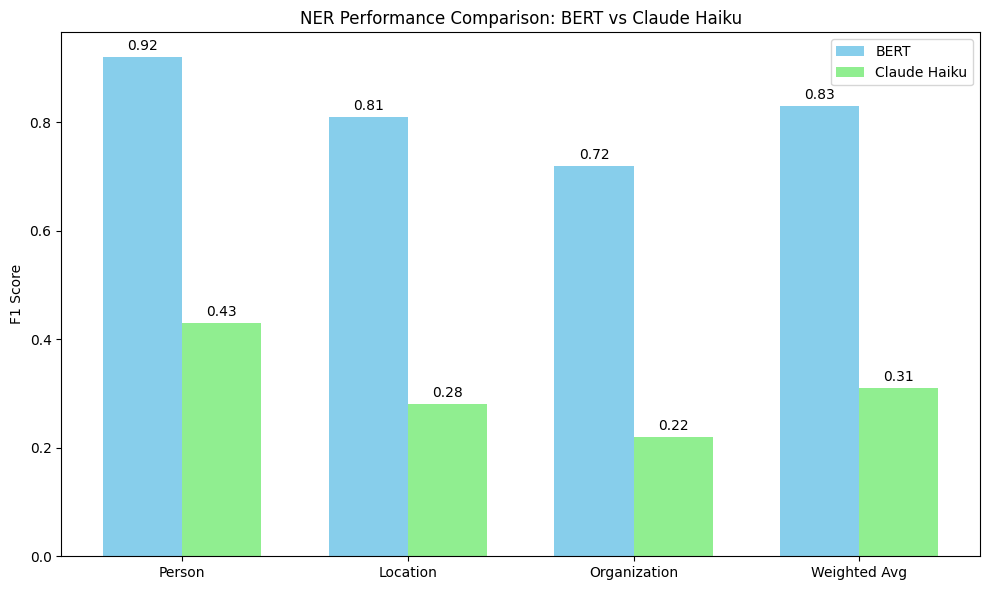

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Hardcode BERT metrics
bert_metrics = {
    'PER_f1': 0.92,
    'LOC_f1': 0.81,
    'ORG_f1': 0.72,
    'weighted_avg_f1': 0.83
}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar and positions of the bars
width = 0.35
x = np.arange(len(bert_metrics))

# Create bars
bert_bars = ax.bar(x - width/2, bert_metrics.values(), width, label='BERT', color='skyblue')
llm_bars = ax.bar(x + width/2, [metrics['PER_f1'], metrics['LOC_f1'], metrics['ORG_f1'], metrics['weighted_avg_f1']],
                 width, label='Claude Haiku', color='lightgreen')

# Customize the plot
ax.set_ylabel('F1 Score')
ax.set_title('NER Performance Comparison: BERT vs Claude Haiku')
ax.set_xticks(x)
ax.set_xticklabels(['Person', 'Location', 'Organization', 'Weighted Avg'])
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bert_bars)
autolabel(llm_bars)

# Ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()